In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import pickle
import time 
from PIL import Image

print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose

# Good pickle files to use:
# 1753840418
# 1753840146 (frame 35)
# 1753913339 (with state data)

# Load ManiSkill demo pickle file
pickle_path = '/data/maddie/predictive_safety_filters/demos/coffee_table/keyboard/1754005959.pickle'
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

print("Loaded keys:", data.keys())

print("Num images:", len(data["images"]))
print("Num ee_states:", len(data["ee_states"]))
print("Num actions:", len(data["actions"]))

Cuda available: True
Loaded keys: dict_keys(['state_dict', 'actions', 'images', 'ee_states'])
Num images: 38
Num ee_states: 38
Num actions: 38


In [2]:
images = data['images']  # list of lists of PIL images
print(f"\nNum time steps: {len(images)}")
print(f"Num cameras per time step: {len(images[0])}")
print(f"Original image shape: {np.array(images[0][0]).shape}")  # (1, 512, 512, 3)



Num time steps: 38
Num cameras per time step: 4
Original image shape: (1, 512, 512, 3)


In [3]:
def resize_image(img_array, size=(256, 256)):
    """
    Resize a HxWxC NumPy image array to the given size.

    Args:
        img_array (np.ndarray): Input image of shape (H, W, C)
        size (tuple): Target size (width, height)

    Returns:
        np.ndarray: Resized image of shape (size[1], size[0], C)
    """
    img_pil = Image.fromarray(img_array.astype(np.uint8))
    img_resized = img_pil.resize(size, resample=Image.BILINEAR)
    return np.array(img_resized)


In [4]:
print(type(data['images']))
print(f"Length of images list: {len(data['images'])}")
print("First element type:", type(data['images'][0]))
print("First element shape (after np.array):", np.array(data['images'][2]).shape)


<class 'list'>
Length of images list: 38
First element type: <class 'list'>
First element shape (after np.array): (4, 1, 512, 512, 3)


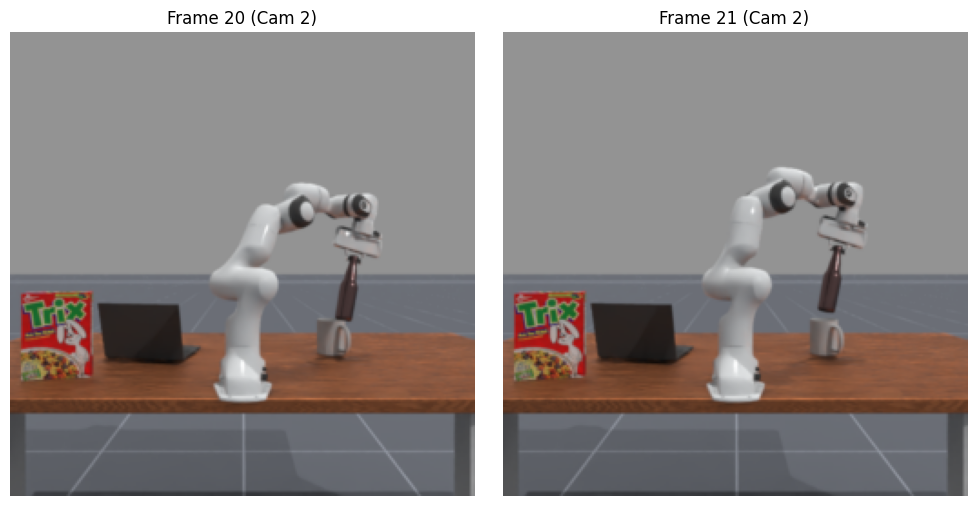

In [5]:
camera_idx = 2
t_curr = 20

# Extract raw images
img_raw_t = data['images'][t_curr][camera_idx]       # shape (1, 512, 512, 3)
img_raw_t1 = data['images'][t_curr + 1][camera_idx]  # shape (1, 512, 512, 3)

# Remove the extra batch dim and resize
img1 = resize_image(img_raw_t[0])  # shape (512, 512, 3) → resized
img2 = resize_image(img_raw_t1[0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1)
axs[0].set_title(f"Frame {t_curr} (Cam {camera_idx})")
axs[1].imshow(img2)
axs[1].set_title(f"Frame {t_curr+1} (Cam {camera_idx})")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

In [6]:
# Stack into [2, H, W, C]
np_imgs = np.stack([img1, img2], axis=0)  # shape: (2, 256, 256, 3)

# Normalize and convert to tensor
tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0  # [2, 256, 256, 3]
tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, 256, 256]
clips = tensor_imgs.unsqueeze(0)  # [1, 3, 2, 256, 256]
print("Clips shape:", clips.shape)  # Should be [1, 3, 2, 256, 256]

Clips shape: torch.Size([1, 3, 2, 256, 256])


In [7]:
# Action shape: [1, 1, 7]
action = data["actions"][t_curr].unsqueeze(0).unsqueeze(0).to(device)

# print("Action shape:", action.shape)  # Should be [1, 1, 7]
# # EE state shape: [1, 1, 8]
# state = torch.tensor(data["ee_states"][t_curr], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
# print("EE state shape:", state.shape)  # Should be [1, 1, 8]

In [8]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import torch

# Step 1: Stack raw ee_states into a NumPy array
ee_states_np = np.stack(data["ee_states"])  # Shape: (T, 8)

# Step 2: Extract parts
positions = ee_states_np[:, :3]       # (T, 3)
quaternions = ee_states_np[:, 3:7]    # (T, 4)
grippers = ee_states_np[:, 7:]        # (T, 1)

# Step 3: Convert quaternions to Euler angles (in radians)
eulers = R.from_quat(quaternions).as_euler('xyz', degrees=False)  # (T, 3)

# Step 4: Concatenate into (T, 7) format
ee_states_7d_np = np.concatenate([positions, eulers, grippers], axis=1)

# Step 5: Convert to Torch tensor
ee_states_7d = torch.tensor(ee_states_7d_np, dtype=torch.float32)  # Shape: (T, 7)
print(f"Final ee_states shape: {ee_states_7d.shape}")
print(f"Example state:\n{ee_states_7d[0]}")


Final ee_states shape: torch.Size([38, 7])
Example state:
tensor([-0.5031, -0.6347,  0.2578,  3.1303, -0.0036, -3.1051,  0.0400])


In [15]:
# ------------------------------
# 🔌 Load V-JEPA 2 Model
# ------------------------------

encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)
clips = clips.to(device)
action = action.to(device)
ee_states_7d = ee_states_7d.to(device)
state = ee_states_7d[t_curr].unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, 7]
print("State shape:", state.shape)  # Should be [1, 1, 7]

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main


State shape: torch.Size([1, 1, 7])


In [10]:
# ------------------------------
# Define tokens_per_frame
# ------------------------------
crop_size = 256  # usually 256
patch_size = encoder.patch_size  # usually 16
tokens_per_frame = (crop_size // patch_size) ** 2
print(f"Patch size: {patch_size}, Tokens per frame: {tokens_per_frame}")

Patch size: 16, Tokens per frame: 256


In [16]:
# ------------------------------
# 🧠 Define Encoding step, predicting step, and L1 Loss functions
# ------------------------------

def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    print("z_hat shape:", z_hat.shape)   # visual tokens
    print("action shape:", a_hat.shape)  # should be 3D: [B, T, D]
    print("state shape:", s_hat.shape)   # should be 3D: [B, T, D]

    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    """
    Compute the L1 Loss (Average Absolute Error) between predicted and target latent tokens.
    """
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2])



In [17]:
# ------------------------------
# 🔮 Encode, Predict
# ------------------------------

# start tracking time it takes to encode and predict
start_time = time.time()

# Encode visual context and split
h = forward_target(clips)  # encode the input clips (frame_t and frame_t+1)
print("action shape:", action.shape)     # Expecting [1, 1, 7]
print("ee_states_7d shape:", ee_states_7d.shape)  # Currently [T, 7], need to slice it!
print("selected state shape:",state.shape)  # Should be [7]

# predict next latent tokens
z_next_pred, _ = step_predictor(h[:, :tokens_per_frame], action, state)

# end tracking time it takes to encode and predict
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.4f} seconds")


action shape: torch.Size([1, 1, 7])
ee_states_7d shape: torch.Size([38, 7])
selected state shape: torch.Size([1, 1, 7])
z_hat shape: torch.Size([1, 256, 1408])
action shape: torch.Size([1, 1, 7])
state shape: torch.Size([1, 1, 7])
Prediction time: 0.1495 seconds


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [18]:
# ------------------------------
# 📉 Evaluate
# ------------------------------

# L1 Loss: Measures how far the predicted latent tokens are from the ground truth in raw numbers.
loss = loss_fn(z_next_pred, h[:, tokens_per_frame:])
print(f"\n Prediction L1 Loss: {loss.item():.4f}")

# Cosine Similarity: Measures angular similarity between predicted and true tokens.
cos_sim = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()
print(f"\n Cosine Similarity: {cos_sim:.4f}")

print(f"\n Cannot compute MSE loss becuase we dont have access to the state")



 Prediction L1 Loss: 0.5285

 Cosine Similarity: 0.7384

 Cannot compute MSE loss becuase we dont have access to the state


Cuda available: True
Loaded keys: dict_keys(['state_dict', 'actions', 'images', 'ee_states'])
Num time steps: 38
Num cameras per time step: 4
Original image shape: (1, 512, 512, 3)


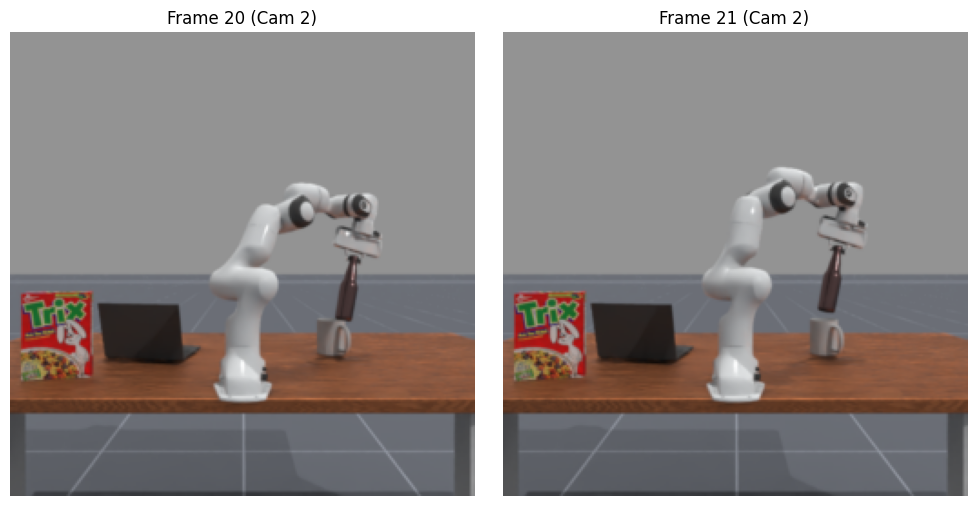

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main


Patch size: 16, Tokens per frame: 256
Prediction time: 0.0986 seconds

Prediction L1 Loss: 0.5285
Cosine Similarity: 0.7384


In [20]:
# ----------------------------------------
# 📦 Imports & Setup
# ----------------------------------------

import sys
sys.path.insert(0, "..")

import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R

import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose

# Check CUDA
print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------
# 📂 Load Demo Data
# ----------------------------------------

pickle_path = '/data/maddie/predictive_safety_filters/demos/coffee_table/keyboard/1754005959.pickle'
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

print("Loaded keys:", data.keys())
print(f"Num time steps: {len(data['images'])}")
print(f"Num cameras per time step: {len(data['images'][0])}")
print(f"Original image shape: {np.array(data['images'][0][0]).shape}")

# ----------------------------------------
# 🖼️ Image Processing
# ----------------------------------------

def resize_image(img_array, size=(256, 256)):
    img_pil = Image.fromarray(img_array.astype(np.uint8))
    return np.array(img_pil.resize(size, resample=Image.BILINEAR))

camera_idx = 2
t_curr = 20

img_raw_t = data['images'][t_curr][camera_idx][0]
img_raw_t1 = data['images'][t_curr + 1][camera_idx][0]

img1 = resize_image(img_raw_t)
img2 = resize_image(img_raw_t1)

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1); axs[0].set_title(f"Frame {t_curr} (Cam {camera_idx})")
axs[1].imshow(img2); axs[1].set_title(f"Frame {t_curr+1} (Cam {camera_idx})")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

# Stack and normalize
np_imgs = np.stack([img1, img2], axis=0)  # (2, 256, 256, 3)
tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0
tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, 256, 256]
clips = tensor_imgs.unsqueeze(0).to(device)   # [1, 3, 2, 256, 256]

# ----------------------------------------
# 🤖 Action and State
# ----------------------------------------

action = data["actions"][t_curr].unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 7]

# Convert EE state from quaternion to 7D (position, euler, gripper)
ee_states_np = np.stack(data["ee_states"])  # (T, 8)
positions = ee_states_np[:, :3]
quaternions = ee_states_np[:, 3:7]
grippers = ee_states_np[:, 7:]
eulers = R.from_quat(quaternions).as_euler('xyz', degrees=False)
ee_states_7d_np = np.concatenate([positions, eulers, grippers], axis=1)
ee_states_7d = torch.tensor(ee_states_7d_np, dtype=torch.float32).to(device)  # (T, 7)

state = ee_states_7d[t_curr].unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 7]

# ----------------------------------------
# ⚙️ Load V-JEPA 2 Model
# ----------------------------------------

encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)

crop_size = 256
patch_size = encoder.patch_size
tokens_per_frame = (crop_size // patch_size) ** 2

print(f"Patch size: {patch_size}, Tokens per frame: {tokens_per_frame}")

# ----------------------------------------
# 🔄 Encoding & Prediction
# ----------------------------------------

def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    return F.layer_norm(h, (h.size(-1),)) if normalize_reps else h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    z = z[:, -tokens_per_frame:]
    h = h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2])

# Encode and predict
start_time = time.time()
h = forward_target(clips)
z_next_pred, _ = step_predictor(h[:, :tokens_per_frame], action, state)
end_time = time.time()

print(f"Prediction time: {end_time - start_time:.4f} seconds")

# ----------------------------------------
# 📉 Evaluation
# ----------------------------------------

loss = loss_fn(z_next_pred, h[:, tokens_per_frame:])
cos_sim = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()

print(f"\nPrediction L1 Loss: {loss.item():.4f}")
print(f"Cosine Similarity: {cos_sim:.4f}")


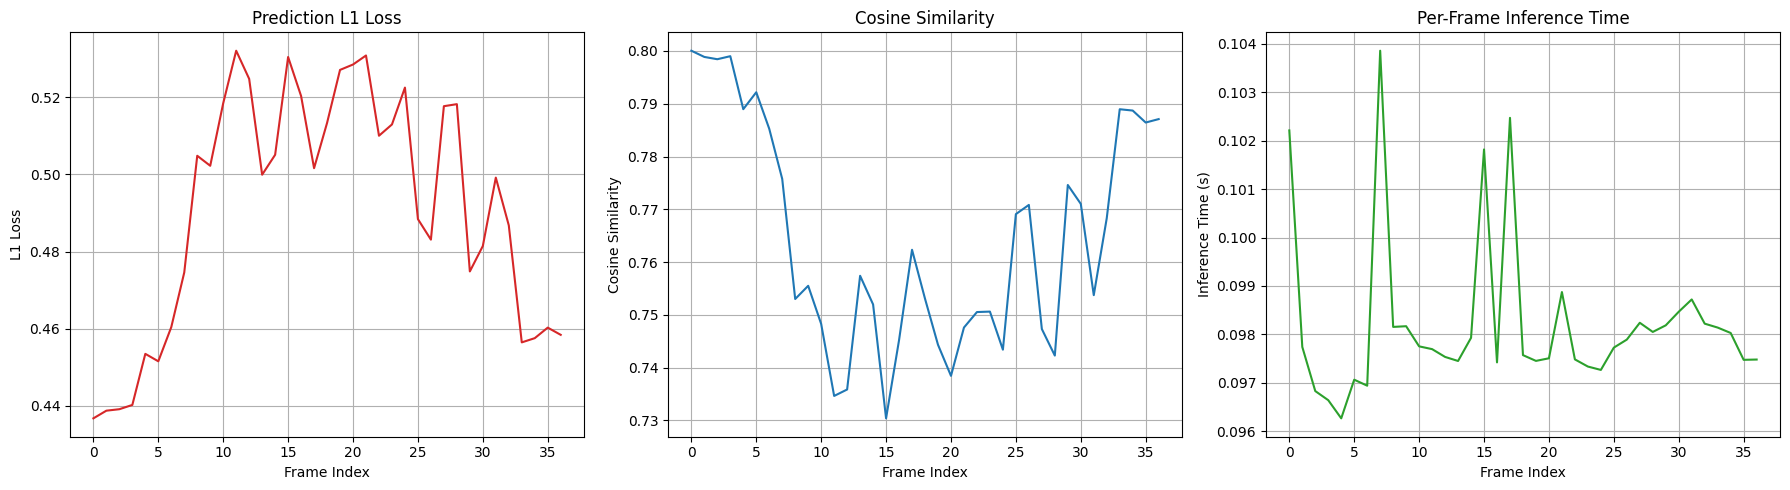

In [22]:
# ----------------------------------------
# 🔁 Loop Through All Image Pairs w/ Inference Timing
# ----------------------------------------

l1_losses = []
cos_sims = []
inference_times = []
frame_indices = []

camera_idx = 2  # Change if needed

for t_curr in range(len(data["images"]) - 1):
    try:
        # ------------------------------
        # Image preprocessing
        # ------------------------------
        img_t = resize_image(data["images"][t_curr][camera_idx][0])
        img_t1 = resize_image(data["images"][t_curr + 1][camera_idx][0])
        
        np_imgs = np.stack([img_t, img_t1], axis=0)
        tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0
        tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, 256, 256]
        clips = tensor_imgs.unsqueeze(0).to(device)   # [1, 3, 2, 256, 256]

        # ------------------------------
        # Actions and EE state
        # ------------------------------
        action = data["actions"][t_curr].unsqueeze(0).unsqueeze(0).to(device)
        state = ee_states_7d[t_curr].unsqueeze(0).unsqueeze(0).to(device)

        # ------------------------------
        # Encode and Predict (timed)
        # ------------------------------
        start_time = time.time()
        h = forward_target(clips)
        z_next_pred, _ = step_predictor(h[:, :tokens_per_frame], action, state)
        end_time = time.time()

        inference_time = end_time - start_time

        # ------------------------------
        # Metrics
        # ------------------------------
        l1 = loss_fn(z_next_pred, h[:, tokens_per_frame:])
        cos = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()

        # Store results
        l1_losses.append(l1.item())
        cos_sims.append(cos)
        inference_times.append(inference_time)
        frame_indices.append(t_curr)

    except Exception as e:
        print(f"⚠️ Skipping frame {t_curr} due to error: {e}")
        continue

# ----------------------------------------
# 📊 Plot Metrics
# ----------------------------------------

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(frame_indices, l1_losses, color='tab:red')
plt.xlabel("Frame Index")
plt.ylabel("L1 Loss")
plt.title("Prediction L1 Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(frame_indices, cos_sims, color='tab:blue')
plt.xlabel("Frame Index")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(frame_indices, inference_times, color='tab:green')
plt.xlabel("Frame Index")
plt.ylabel("Inference Time (s)")
plt.title("Per-Frame Inference Time")
plt.grid(True)

plt.tight_layout()
plt.show()
